In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

device = 'cuda:0'

In [2]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np

from jax.experimental import stax
from jax.experimental import optimizers

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

import time
import imageio
import json
import os

import numpy as onp

from IPython.display import clear_output

## Random seed
rand_key = random.PRNGKey(0)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

basedir = '' # base output dir

import trimesh
import pyembree

/scratch/wangh19/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/scratch/wangh19/anaconda3/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/scratch/wangh19/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [3]:
def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(scene_or_mesh, trimesh.Trimesh))
        mesh = scene_or_mesh
    return mesh


def recenter_mesh(mesh):
  mesh.vertices -= mesh.vertices.mean(0)
  mesh.vertices /= np.max(np.abs(mesh.vertices))
  mesh.vertices = .5 * (mesh.vertices + 1.)


def load_mesh(mesh_name, verbose=True):

  mesh = trimesh.load(mesh_files[mesh_name])
  mesh = as_mesh(mesh)
  if verbose: 
    print(mesh.vertices.shape)
  recenter_mesh(mesh)

  c0, c1 = mesh.vertices.min(0) - 1e-3, mesh.vertices.max(0) + 1e-3
  corners = [c0, c1]
  if verbose:
    print(c0, c1)
    print(c1-c0)
    print(np.prod(c1-c0))
    print(.5 * (c0+c1) * 2 - 1)

    
  test_pt_file = os.path.join(logdir, mesh_name + '_test_pts.npy')
  if not os.path.exists(test_pt_file):
    if verbose: print('regen pts')
    test_pts = np.array([make_test_pts(mesh, corners), make_test_pts(mesh, corners)])
    np.save(test_pt_file, test_pts)
  else:
    if verbose: print('load pts')
    test_pts = np.load(test_pt_file)

  if verbose: print(test_pts.shape)

  return mesh, corners, test_pts


###################



def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(1))
  return stax.serial(*layers)


input_encoder = jit(lambda x, a, b: (np.concatenate([a * np.sin((2.*np.pi*x) @ b.T), 
                                                     a * np.cos((2.*np.pi*x) @ b.T)], axis=-1) / np.linalg.norm(a)) if a is not None else (x * 2. - 1.))



trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    # c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w



def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1, 2,))

#########


def render_rays_native_hier(params, ab, rays, corners, near, far, N_samples, N_samples_2, clip): #, rand=False):
    rays_o, rays_d = rays[0], rays[1]
    c0, c1 = corners

    th = .5
    
    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    alpha = jax.nn.sigmoid(np.squeeze(apply_fn(params, input_encoder(.5 * (pts + 1), *ab))))
    if clip:
      mask = np.logical_or(np.any(.5 * (pts + 1) < c0, -1), np.any(.5 * (pts + 1) > c1, -1))
      alpha = np.where(mask, 0., alpha)

    alpha = np.where(alpha > th, 1., 0)

    trans = 1.-alpha + 1e-10
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    depth_map = np.sum(weights * z_vals, -1) 
    acc_map = np.sum(weights, -1)

    # Second pass to refine isosurface

    z_vals = np.linspace(-1., 1., N_samples_2) * .01 + depth_map[...,None]
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    alpha = jax.nn.sigmoid(np.squeeze(apply_fn(params, input_encoder(.5 * (pts + 1), *ab))))
    if clip:
      # alpha = np.where(np.any(np.abs(pts) > 1, -1), 0., alpha)
      mask = np.logical_or(np.any(.5 * (pts + 1) < c0, -1), np.any(.5 * (pts + 1) > c1, -1))
      alpha = np.where(mask, 0., alpha)

    alpha = np.where(alpha > th, 1., 0)

    trans = 1.-alpha + 1e-10
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    depth_map = np.sum(weights * z_vals, -1) 
    acc_map = np.sum(weights, -1)

    return depth_map, acc_map

render_rays = jit(render_rays_native_hier, static_argnums=(6,7,8))
# render_rays = render_rays_native_hier



@jit
def make_normals(rays, depth_map):
  rays_o, rays_d = rays
  pts = rays_o + rays_d * depth_map[...,None]
  dx = pts - np.roll(pts, -1, axis=0)
  dy = pts - np.roll(pts, -1, axis=1)
  normal_map = np.cross(dx, dy)
  normal_map = normal_map / np.maximum(np.linalg.norm(normal_map, axis=-1, keepdims=True), 1e-5)
  return normal_map


def render_mesh_normals(mesh, rays):
  origins, dirs = rays.reshape([2,-1,3])
  origins = origins * .5 + .5
  dirs = dirs * .5
  z = mesh.ray.intersects_first(origins, dirs)
  pic = onp.zeros([origins.shape[0],3]) 
  pic[z!=-1] = mesh.face_normals[z[z!=-1]]
  pic = np.reshape(pic, rays.shape[1:])
  return pic

def uniform_bary(u):
  su0 = np.sqrt(u[..., 0])
  b0 = 1. - su0
  b1 = u[..., 1] * su0
  return np.stack([b0, b1, 1. - b0 - b1], -1)


def get_normal_batch(mesh, bsize):

  batch_face_inds = np.array(onp.random.randint(0, mesh.faces.shape[0], [bsize]))
  batch_barys = np.array(uniform_bary(onp.random.uniform(size=[bsize, 2])))
  batch_faces = mesh.faces[batch_face_inds]
  batch_normals = mesh.face_normals[batch_face_inds]
  batch_pts = np.sum(mesh.vertices[batch_faces] * batch_barys[...,None], 1)

  return batch_pts, batch_normals


def make_test_pts(mesh, corners, test_size=2**18):
  c0, c1 = corners
  test_easy = onp.random.uniform(size=[test_size, 3]) * (c1-c0) + c0
  batch_pts, batch_normals = get_normal_batch(mesh, test_size)
  test_hard = batch_pts + onp.random.normal(size=[test_size,3]) * .01
  return test_easy, test_hard

gt_fn = lambda queries, mesh : mesh.ray.contains_points(queries.reshape([-1,3])).reshape(queries.shape[:-1])


In [4]:

embedding_size = 256
embedding_method = 'gaussian'
embedding_param = 12.
embed_params = [embedding_method, embedding_size, embedding_param]
init_fn, apply_fn = make_network(8, 256)

batch_size = 64*64*2 * 4
lr = 5e-4
step = optimizers.exponential_decay(lr, 500, .9)


In [5]:
def run_training(embed_params, mesh, corners, test_pts, render_args_lr, name='', N_iters = 400, intervals = 10):

  validation_pts, testing_pts = test_pts

  N = 256
  x_test = np.linspace(0.,1.,N, endpoint=False) * 1.
  x_test = np.stack(np.meshgrid(*([x_test]*2), indexing='ij'), -1)
  queries_plot = np.concatenate([x_test, .5 + np.zeros_like(x_test[...,0:1])], -1)

  embedding_method, embedding_size, embedding_scale = embed_params
  c0, c1 = corners

  if embedding_method == 'gauss':
    print('gauss bvals')
    bvals = onp.random.normal(size=[embedding_size,3]) * embedding_scale

  if embedding_method == 'posenc':
    print('posenc bvals')
    bvals = 2.**np.linspace(0,embedding_scale,embedding_size//3) - 1
    bvals = np.reshape(np.eye(3)*bvals[:,None,None], [len(bvals)*3, 3])

  if embedding_method == 'basic':
    print('basic bvals')
    bvals = np.eye(3)


  if embedding_method == 'none':
    print('NO abvals')
    avals = None
    bvals = None
  else:
    avals = np.ones_like(bvals[:,0])

  ab = (avals, bvals)
  x_enc = input_encoder(np.ones([1,3]), avals, bvals)
  print(x_enc.shape)

  _, net_params = init_fn(rand_key, (-1, x_enc.shape[-1]))

  opt_init, opt_update, get_params = optimizers.adam(step)
  opt_state = opt_init(net_params)

  @jit
  def network_pred(params, inputs):
    return jax.nn.sigmoid(np.squeeze(apply_fn(params, input_encoder(inputs, *ab))))

  @jit
  def loss_fn(params, inputs, z):
    x = (np.squeeze(apply_fn(params, input_encoder(inputs, *ab))[...,0]))
    loss_main = np.mean(np.maximum(x, 0) - x * z + np.log(1 + np.exp(-np.abs(x))))
    return loss_main

  @jit
  def step_fn(i, opt_state, inputs, outputs):
    params = get_params(opt_state)
    g = grad(loss_fn)(params, inputs, outputs)
    return opt_update(i, g, opt_state)
    
  psnrs = []
  losses = []
  tests = [[],[]]
  xs = []

  gt_val = [gt_fn(test, mesh) for test in validation_pts]

  for i in tqdm(range(N_iters+1)):
    
    inputs = onp.random.uniform(size=[batch_size, 3]) * (c1-c0) + c0
    opt_state = step_fn(i, opt_state, inputs, gt_fn(inputs, mesh))  

    if i%intervals==0:


      renderings = list(render_rays(get_params(opt_state), ab, *render_args_lr))
      renderings.append(make_normals(render_args_lr[0], renderings[0]) * .5 + .5)

      # for to_show in [slices, renderings]:
      for to_show in [renderings,]:
        L = len(to_show)
        plt.figure(figsize=(10*L,8))
        for i, z in enumerate(to_show):
          plt.subplot(1,L,i+1)
          plt.imshow(z)
          plt.colorbar()
          plt.axis('off')
        plt.show()
        plt.close()



  scores = []
  for i, test in enumerate(testing_pts):
    full_pred = network_pred(get_params(opt_state), test)
    outputs = gt_fn(test, mesh)
    val_iou = np.logical_and(full_pred > .5, outputs > .5).sum() / np.logical_or(full_pred > .5, outputs > .5).sum()
    scores.append(val_iou)

  meta_run = [
              (get_params(opt_state), ab),
              np.array(tests),
              scores,
              renderings,
  ]

  return meta_run

In [6]:
R = 2.
# viewing angles
c2w = pose_spherical(30., -30., R)

N_samples = 128
N_samples_2 = 128
H = 180
W = H
focal = H * .9
rays = get_rays(H, W, focal, c2w[:3,:4])

#ray definition

render_args_lr = [get_rays(H, W, focal, c2w[:3,:4]), None, R-1, R+1, N_samples, N_samples_2, True]
  
N_samples = 256
N_samples_2 = 256
H = 512
W = H
focal = H * .9
rays = get_rays(H, W, focal, c2w[:3,:4])

render_args_hr = [get_rays(H, W, focal, c2w[:3,:4]), None, R-1, R+1, N_samples, N_samples_2, True]



In [7]:
# Put your mesh files here
mesh_files = {
    'woman'    : 'woman.obj',
}

logdir = os.path.join(basedir, 'occupancy_logs')
os.makedirs(logdir, exist_ok=True)

occupancy_logs/full_runs


(53333, 3)
[ 0.34151143 -0.001       0.30577433] [0.65493318 0.96985952 0.87097247]
[0.31342175 0.97085952 0.56519813]
0.17198329
[-0.00355539 -0.03114048  0.1767468 ]
load pts
(2, 2, 262144, 3)


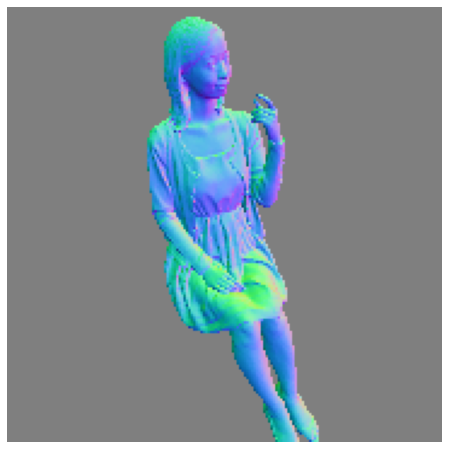

woman_gauss_6.0
gauss bvals
(1, 512)


  0%|          | 0/5001 [00:00<?, ?it/s]

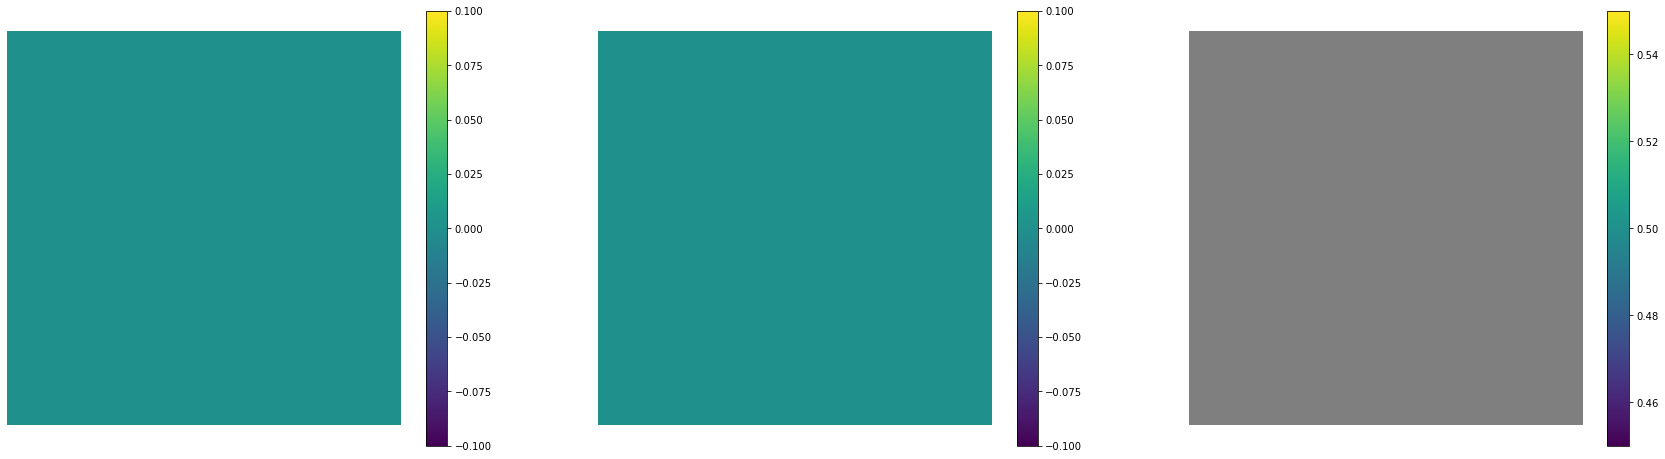

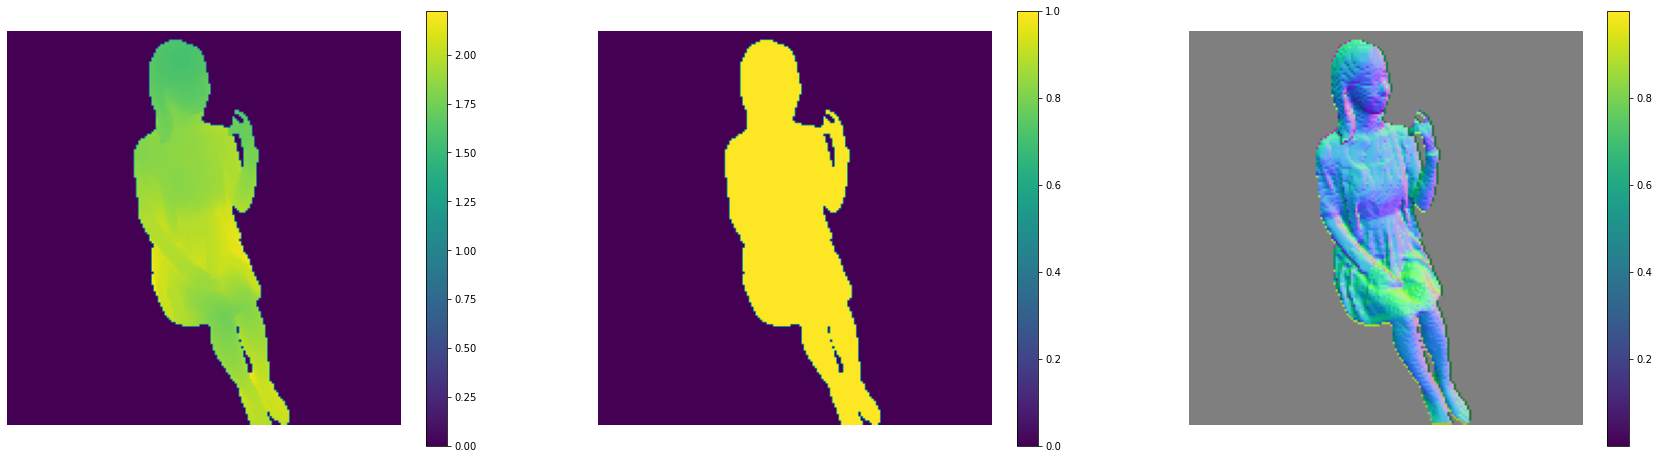

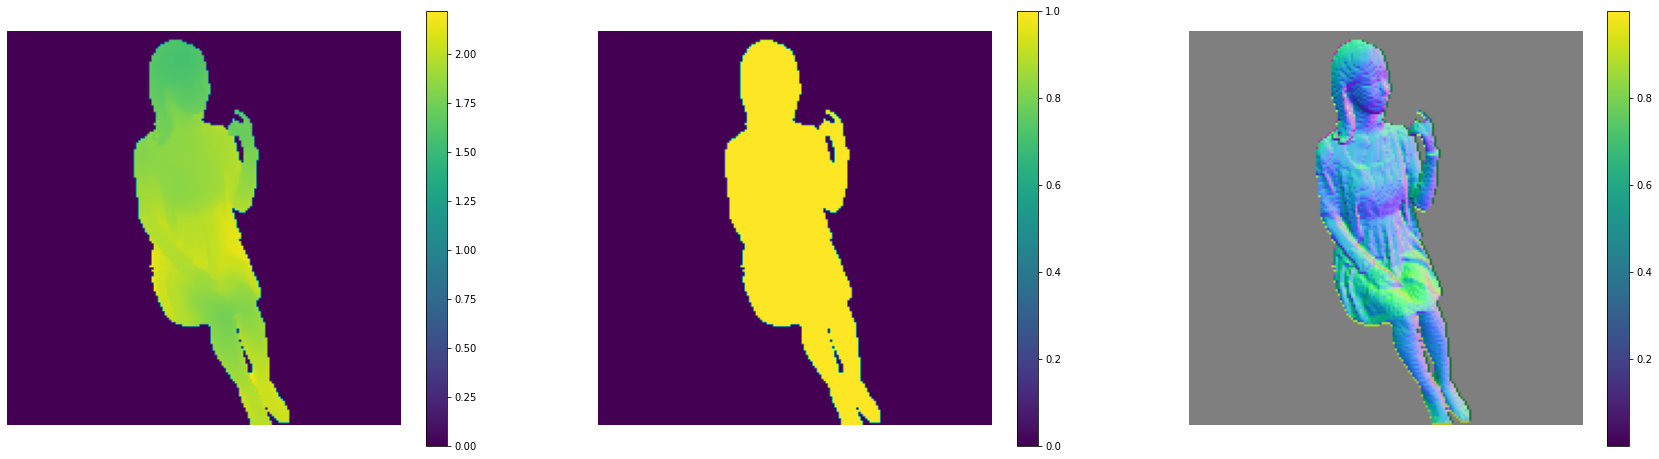

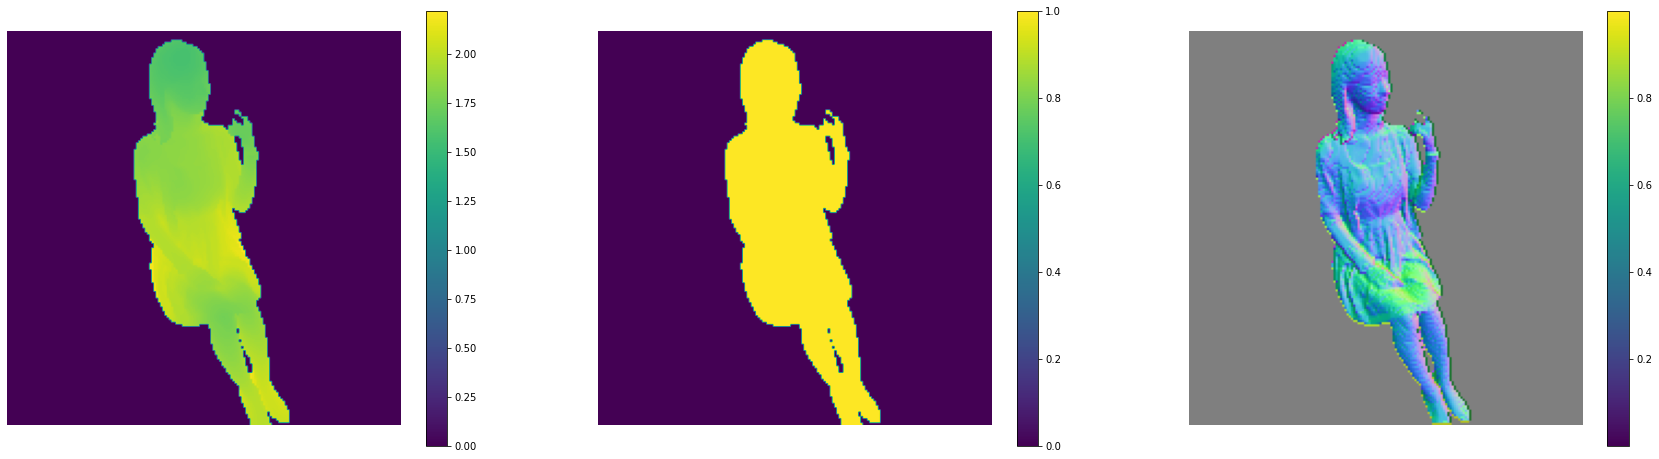

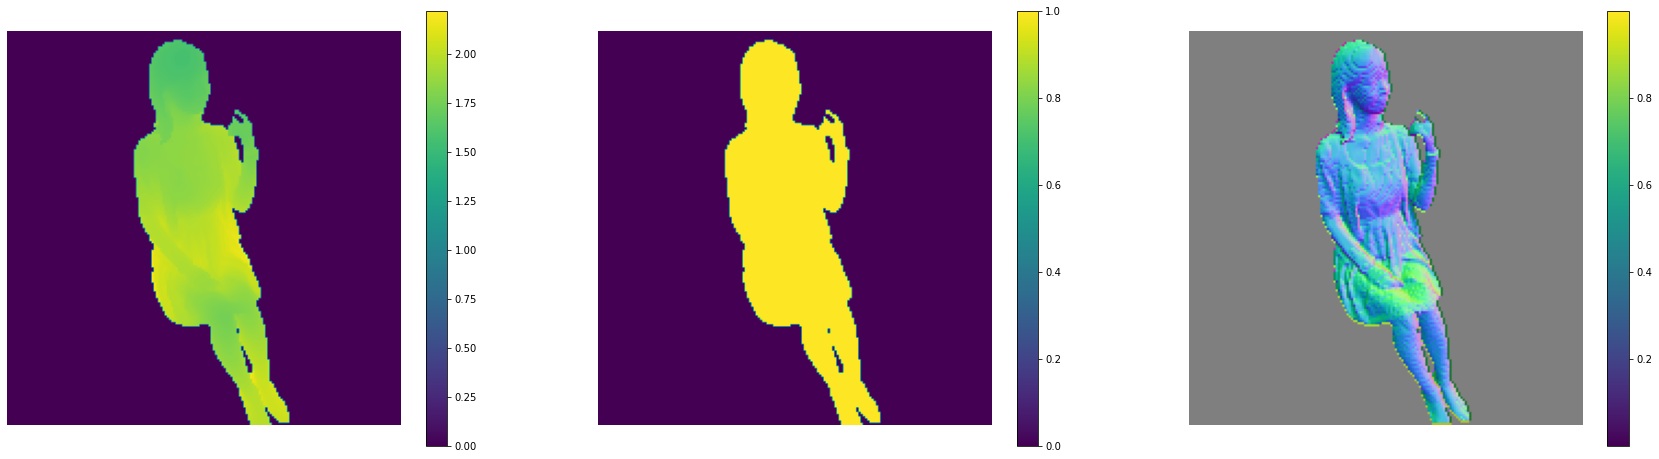

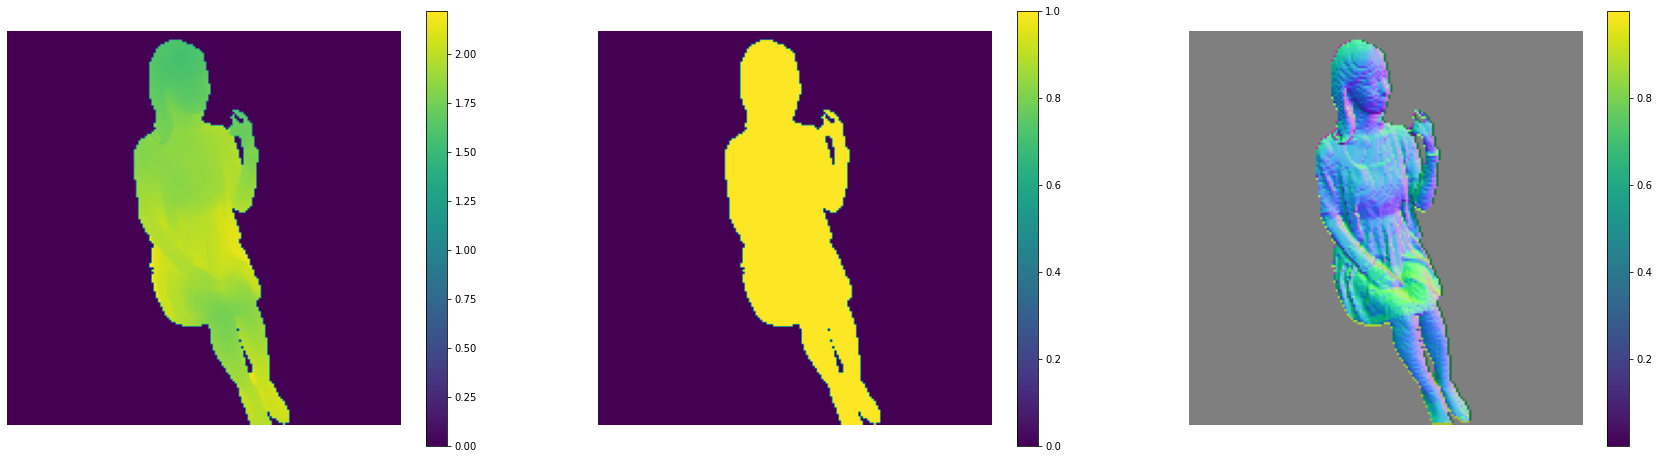

woman_posenc_6.0
posenc bvals
(1, 510)


  0%|          | 0/5001 [00:00<?, ?it/s]

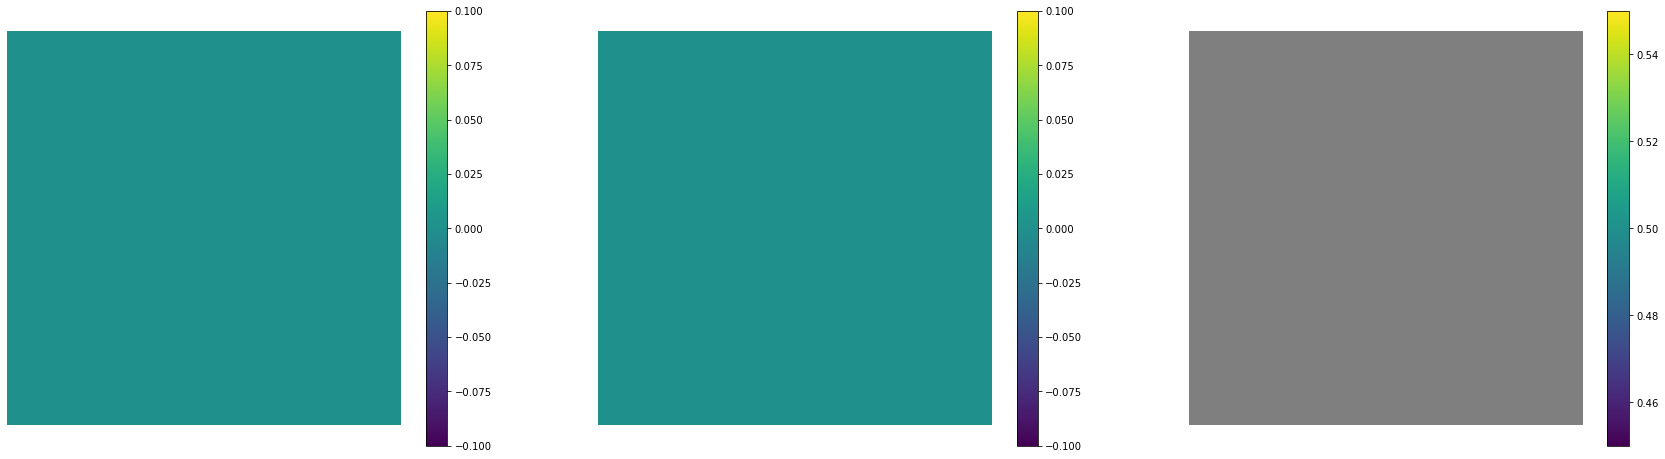

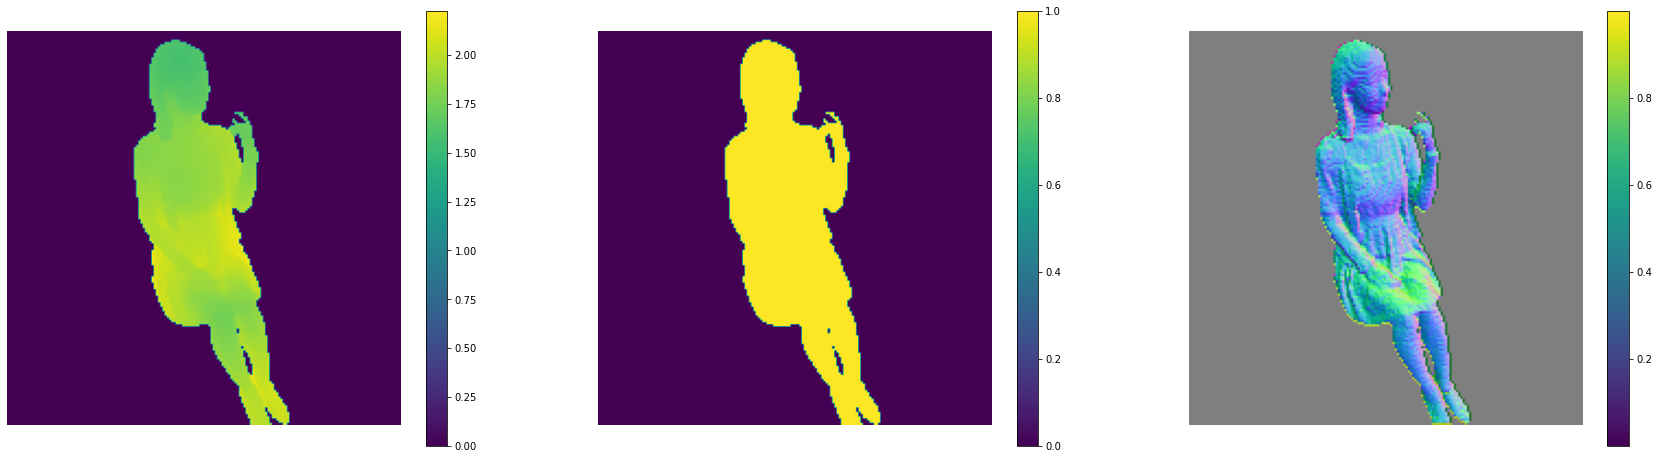

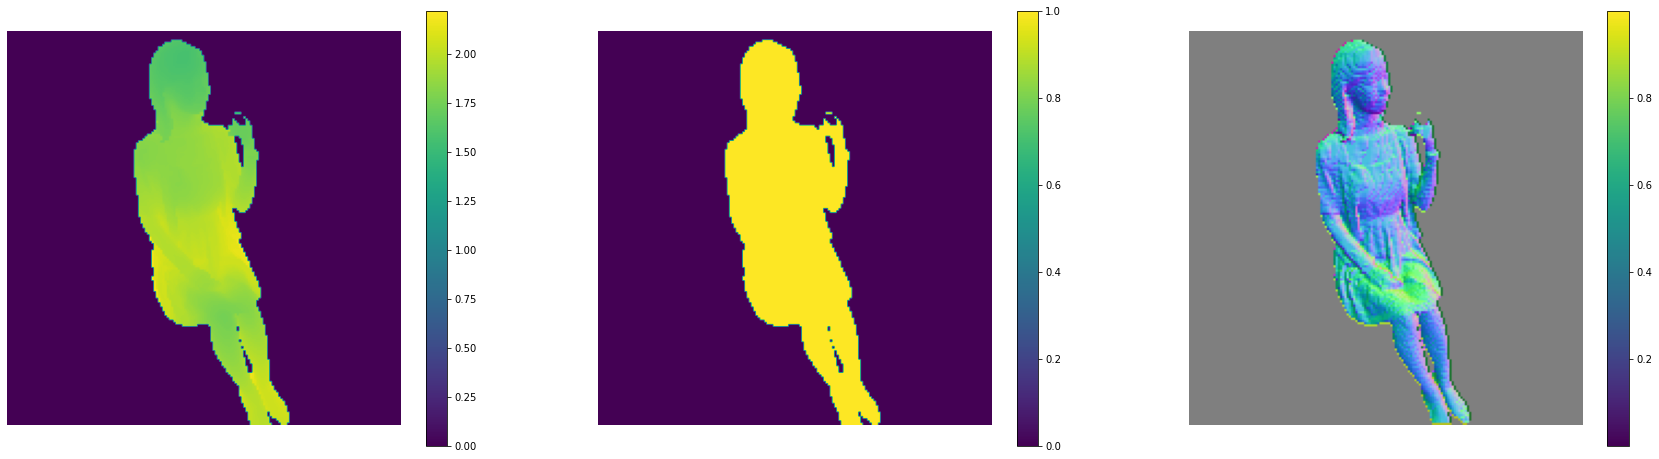

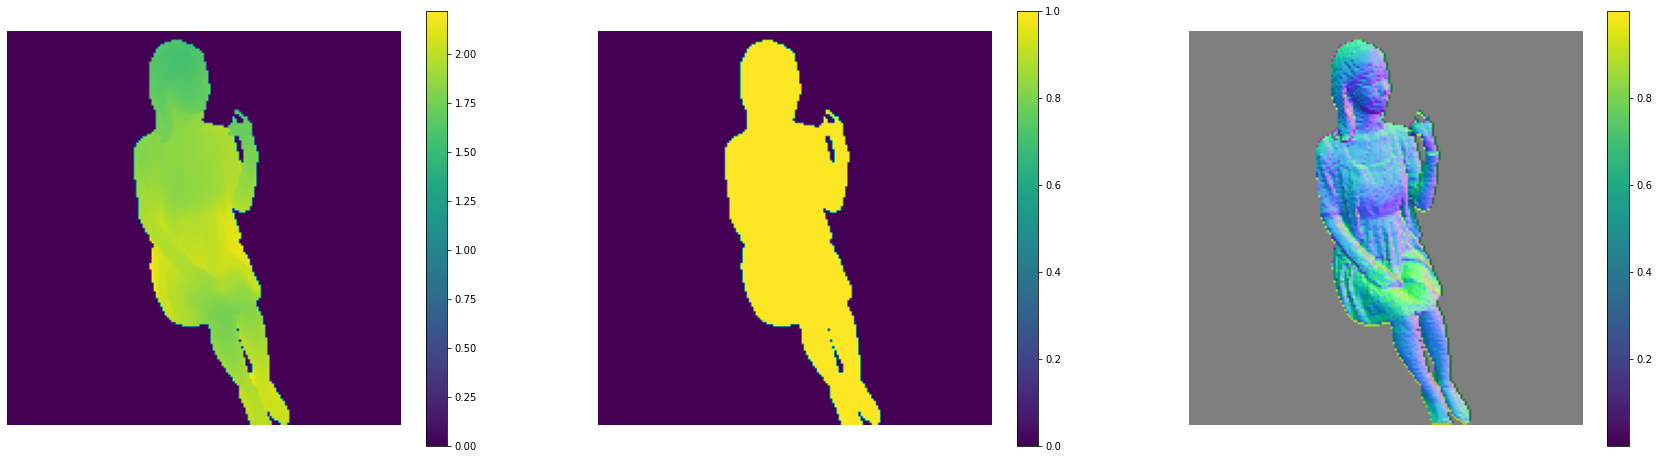

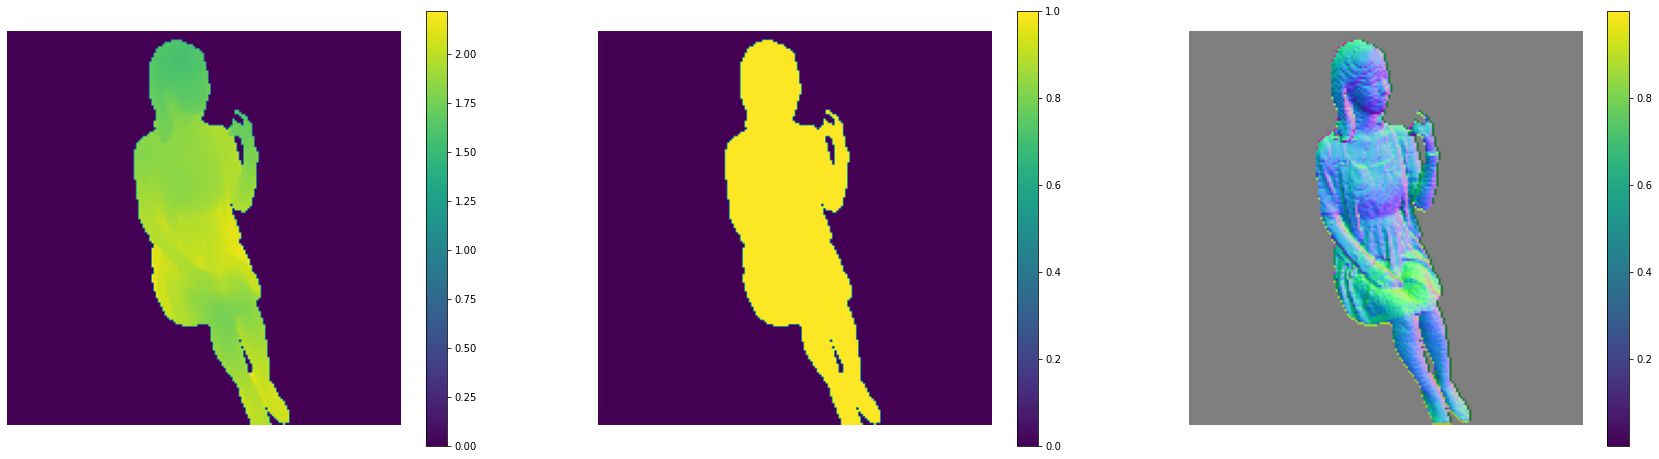

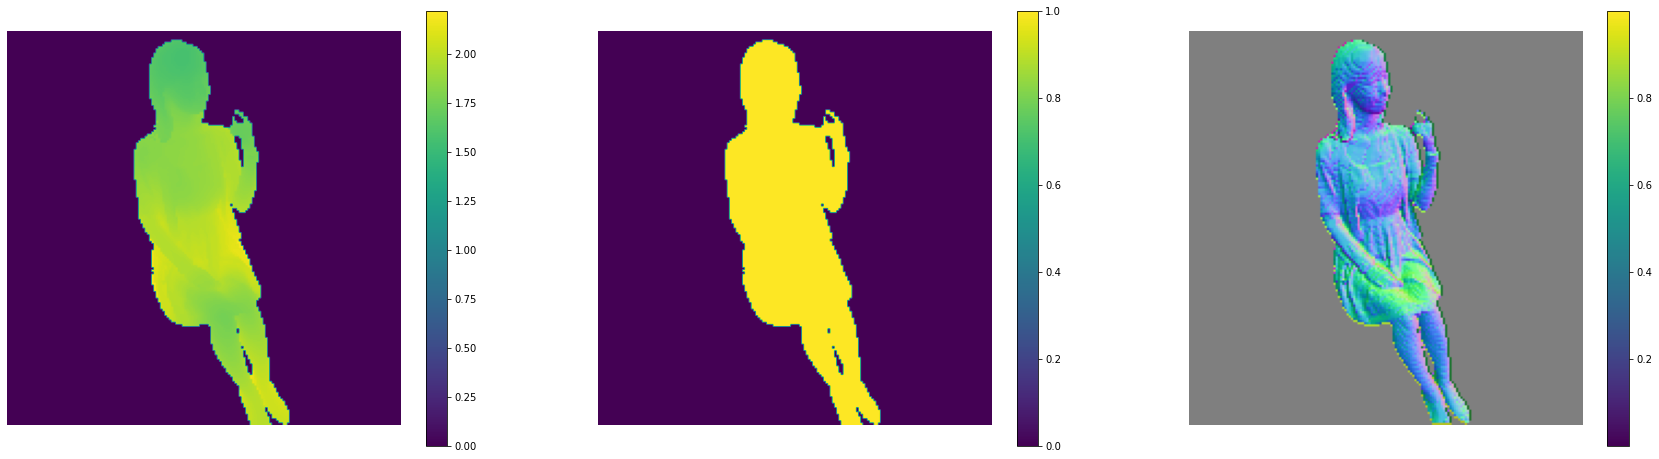

In [8]:

tests_all = {}
out_all = {}
scores = {}

mesh_names = ['woman']

embed_tasks = [
               ['gauss', 256, 6.],
               ['posenc', 256, 6.]
               
]

expdir = os.path.join(logdir, 'full_runs')
os.makedirs(expdir, exist_ok = True)
print(expdir)

for mesh_name in mesh_names:

  # initial preview starts

  mesh, corners, test_pts = load_mesh(mesh_name)

  render_args_lr[1] = corners
  render_args_hr[1] = corners
  plt.figure(figsize = (8,8))

  mesh_normal_map = render_mesh_normals(mesh, render_args_lr[0])
  plt.imshow(mesh_normal_map * .5 + .5)
  plt.axis('off')
  plt.show()
  plt.close()
  # initial preview ends
  
  for embed_params in embed_tasks:
    embedding_method, embedding_size, embedding_param = embed_params

    expname = f'{mesh_name}_{embedding_method}_{embedding_param}'
    print(expname)

    out = run_training(embed_params, mesh, corners, test_pts, render_args_lr, expname, N_iters = 5000, intervals = 1000)
